In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [215]:
import os
import torch
import soundfile as sf
from torch.utils.data import Dataset

import os
import torch
import soundfile as sf
import torchaudio
from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.files = []
        self.labels = []

        # Считываем файлы и метки
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                class_label = int(file_name[0])  # Предполагается, что первый символ - это номер класса
                self.files.append(os.path.join(folder_path, file_name))
                self.labels.append(class_label)

        # Преобразуем метки в one-hot
        self.labels = self.one_hot_encode(self.labels)

    def one_hot_encode(self, labels):
        one_hot = torch.zeros(len(labels), 10)  # Предполагается 10 классов
        for idx, label in enumerate(labels):
            one_hot[idx][label] = 1
        return one_hot

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]

        # Загрузка аудиофайла с использованием soundfile
        waveform, sample_rate = sf.read(file_path)

        # Преобразование в тензор
        waveform = torch.tensor(waveform).float()

        # Преобразование в MFCC
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=13
        )(waveform)

        # Создание спектрограммы
        spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=1024,
            win_length=None,
            hop_length=512,
            power=2.0
        )(waveform)

        if self.transform:
            mfcc = self.transform(mfcc)
            spectrogram = self.transform(spectrogram)

        return mfcc.numpy(), label



In [232]:
folder_path = r'C:\Users\Александр\Downloads\free-spoken-digit-dataset-v1.0.8\Jakobovski-free-spoken-digit-dataset-e9e1155\recordings'
dataset = CustomAudioDataset(folder_path, transform=None)
ds_x = []
ds_y = []

In [224]:
dataset[1000][0].shape

(13, 20)

In [233]:
# Пример доступа к элементам
for i in range(len(dataset)):
    file, label = dataset[i]
    ds_x.append(file)
    ds_y.append(label)

In [138]:
def pad(arrays):
    # Пример списка массивов разной длины    
    # Находим максимальную длину
    max_length = max(len(arr) for arr in arrays)
    
    # Заполняем массивы до максимальной длины
    padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode='constant') for arr in arrays]
    
    # Объединяем массивы
    result = np.array(padded_arrays)

    return result


In [234]:
def pad_2d(arrays):
    
    # Пример списка 2D массивов с разным количеством столбцов
    # Находим максимальное количество столбцов
    max_cols = max(arr.shape[1] for arr in arrays)
    
    # Заполняем массивы до максимального количества столбцов
    padded_arrays = [
        np.pad(arr, ((0, 0), (0, max_cols - arr.shape[1])), mode='constant') 
        for arr in arrays
    ]
    
    # Объединяем массивы по первому измерению (по строкам)
    result = np.stack(padded_arrays)
    

    return result


In [139]:
ds_x = pad(ds_x)
ds_y = np.array(ds_y)

In [235]:
ds_x = pad_2d(ds_x)
ds_y = np.array(ds_y)

In [236]:
ds_x.shape, ds_y.shape


((1500, 13, 92), (1500, 10))

In [13]:
%%cmd
pip install soundfile


Microsoft Windows [Version 10.0.26100.2605]
(c) Microsoft Corporation. All rights reserved.

C:\Users\����ᠭ��\audio>pip install soundfile
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 1.0/1.0 MB 1.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



C:\Users\����ᠭ��\audio>

In [14]:
import soundfile as sf

waveform, sample_rate = sf.read(r"C:\Users\Александр\Downloads\free-spoken-digit-dataset-v1.0.8\Jakobovski-free-spoken-digit-dataset-e9e1155\recordings\0_jackson_13.wav")


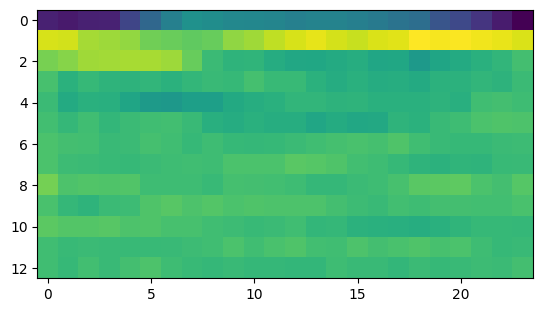

In [7]:
plt.imshow(file)

In [18]:
len(waveform)

4716

In [263]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Создание модели
def cnn_1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(2,13,91)))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = cnn_1()

In [13]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential

In [264]:
model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 1, 12, 32)           │          11,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 1, 12, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 0, 11, 48)           │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 0, 11, 48)           │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 0, 5, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 0, 5, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 0)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 128)                 │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,994 (109.35 KB)

 Trainable params: 27,450 (107.23 KB)

 Non-trainable params: 544 (2.12 KB)

In [265]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
ds_x_train, ds_x_test, ds_y_train, ds_y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", ds_x_train.shape, ds_y_train.shape)
print("Размер тестовой выборки:", ds_x_test.shape, ds_y_test.shape)


Размер обучающей выборки: (1200, 13, 92) (1200, 10)
Размер тестовой выборки: (300, 13, 92) (300, 10)


In [266]:
his = model.fit(ds_x_train, ds_y_train, validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 13, 92), dtype=float32). Expected shape (None, 2, 13, 91), but input has incompatible shape (32, 13, 92)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 13, 92), dtype=float32)
  • training=True
  • mask=None

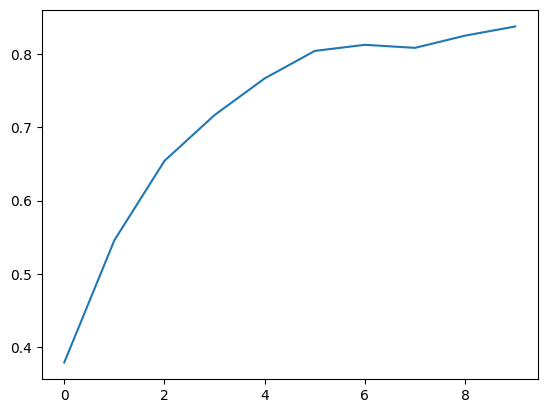

In [247]:
plt.plot(his.history['val_accuracy'])

In [206]:
max(his.history['val_accuracy'])

0.8291666507720947

In [114]:
waveform, sample_rate = sf.read(r"C:\Users\Александр\Downloads\audio_2025-01-14_19-29-50 (mp3cut.net).wav")

# Преобразование в тензор
waveform = torch.tensor(waveform).float()

# Преобразование (например, в MFCC) с использованием torchaudio
mfcc = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=13
)(waveform)


test = mfcc.numpy().flatten()

In [130]:
dnn.predict(tt.reshape(1,1500))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


array([[6.6549915e-26, 3.0408059e-17, 7.1512294e-36, 5.5375400e-22,
        0.0000000e+00, 3.2314272e-08, 9.9532098e-01, 2.0878738e-17,
        7.0822482e-13, 4.6789609e-03]], dtype=float32)

In [115]:
test.shape

(1339,)

In [98]:
ds_y_train.shape

(1200, 1500)

In [118]:
tt = np.pad(test, (0, 1500 - len(test)), mode='constant')

In [120]:
tt.shape

(1500,)

In [155]:
ds_y.shape

(1500, 10)